# Semi-Supervised Learning for Document Classification

In [1]:
# general imports
import pickle
import numpy as np
import pandas as pd
import nltk
import re
from scipy import sparse

In [2]:
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# deep learning frameworks
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [4]:
# nlp processing methods
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /home/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# performance evaluation and dataset processing imports
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

In [6]:
# keras layers used to build models
from keras.layers import Activation,Dense
from keras.layers import Dropout,BatchNormalization,Reshape
from keras.layers import Input,Flatten,Lambda,Concatenate
from keras.regularizers import l2
from keras.models import Model
from keras.losses import mse,categorical_crossentropy

In [7]:
# utilities used for training keras models
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping

## Loading Articles

The first step is to load the preprocessed text in the script in data directory. <br>
The cleaning steps of the text are as follows : <br>
1. convert text of each document to lower case
2. keep all digits/characters of the document (i.e remove all non ascii readable characters)
3. remove punctuation
4. remove stop words
5. build TF-IDF matrix out of the text vocabulary
<br>

The processing steps are done to increase the frequency of words when applying lower case , then removing all un-necessary tokens such as stop words and punctuation. <br>

The descion of using a tf-idf matrix instead of bag of words as it gives a more dense representation of the text and takes into account the frequency of the tokens accross documents and within the document.<br> 

In [ ]:
# load dictionary mapping each category to a list of articles
with open('corpus.pickle', 'rb') as handle:
    corpus = pickle.load(handle)

In [ ]:
stemmer = PorterStemmer()

In [ ]:
def tokenize_stem_document_sentences(sentences):
    
    '''
    :params sentences : a list having each sentence of a document
    
    : returns: a list of lists having for each sentence in a document the corresponding tokens
    '''
    
    def get_sentence_tokens(sentence):
        try:
            tokens = nltk.word_tokenize(sentence)
            stemmed = [stemmer.stem(token) for token in tokens]
            return stemmed
        except: # usually raised for non decodable bytes
            return ''
            
    return list(map(lambda x : get_sentence_tokens(x),sentences))

In [ ]:
def data_cleaning(documents):
    
    '''
    :param documents: a list of strings having the articles of a category
    : returns : a cleaned version of the text
    '''
    
    str_docs = list(map(lambda x: x.encode('utf-8'),documents)) # encode articles from unicode to string
    str_lower = list(map(lambda x:x.lower(),str_docs)) # convert all sentences of the documents to lower case
    
    doc_lines = list(map(lambda x: x.split('\n'),str_lower)) # split by line
    doc_lines = list(filter(lambda x : x!='',doc_lines)) # remove empty lines
    # remove all non characters from text
    regex = re.compile('^[a-zA-Z_ ]*')
    doc_cleaned = list(map(lambda doc : map(lambda sent : regex.sub('',sent),doc),doc_lines)) 
    
    # here str_docs is a list of documents and each entry is a list of sentences
    doc_tokens = list(map(lambda x: tokenize_stem_document_sentences(x),doc_cleaned))
    # combine tokens of all sentences of one document into one list
    doc_tokens = list(map(lambda doc_list : [y for x in doc_list for y in x],doc_tokens))
    
    ## removing punctuation
    regex = re.compile(r'[^\w\s]')
    doc_non_punct = list(map(lambda token_list: list(map(lambda token : regex.sub('',token),token_list)),doc_tokens))
    # keep non empty tokens
    doc_non_punct = list(map(lambda token_list : list(filter(lambda token : token!='',token_list)),doc_non_punct))
    
    
    stop_words =  set(stopwords.words('english'))
    
    doc_fully_cleaned = list(map(lambda token_list : [word for word in token_list if word not in stop_words],doc_non_punct))
    # combine all tokens into one sentence
    doc_fully_cleaned = list(map(lambda token_list : ' '.join(token_list),doc_fully_cleaned))
    return doc_fully_cleaned

In [ ]:
all_corpuses_cleaned = []
data_labels = []
# apply cleaned for all articles of each category 
for counter, value in enumerate(corpus.keys()[:2]):
    cleaned_text = data_cleaning(corpus[value])
    all_corpuses_cleaned = all_corpuses_cleaned + cleaned_text
    data_labels.append(np.full(len(cleaned_text),counter))

In [ ]:
data_labels = np.concatenate(data_labels)

In [ ]:
# saves constructed data to pickles
with open('cleaned_text.pickle','wb') as handle:
    pickle.dump(all_corpuses_cleaned,handle,protocol=2)
with open('cleaned_targets.pickle','wb') as handle:
    pickle.dump(data_labels,handle,protocol=2)

In [8]:
# loads saved data from pickles
with open('cleaned_text.pickle','rb') as handle:
    all_corpuses_cleaned = pickle.load(handle)
with open('cleaned_targets.pickle','rb') as handle:
    data_labels = pickle.load(handle)

### Building the Dataset

In [9]:
def build_dataset(mode='unlabled',points_to_keep=100):
    
    
    # build tf-idf matrix from all documents
    vectorizer = TfidfVectorizer()
    text_data = vectorizer.fit_transform(all_corpuses_cleaned)

    # first we apply a train-test split
    X_train,X_test,y_train,y_test = train_test_split(text_data,data_labels,test_size=0.2,random_state=42)

    if mode == 'unlabled':
        
        labeled_set,labeled_targets = [],[]
        unlabled_set = []

        for targ_label in np.unique(y_train): # iterate over all possible labels

            # subset the data to be kept as labled and keep other points as unlabled
            subset_data = X_train[np.where(y_train==targ_label)[0]]
            labeled_indx = np.random.choice(subset_data.shape[0],points_to_keep)
            mask = np.zeros(subset_data.shape[0],dtype=bool)
            mask[labeled_indx] = True
            labeled_subset = subset_data.tocsr()[mask]
            unlabled_subset = subset_data.tocsr()[~mask]

            labeled_set.append(labeled_subset)
            labeled_targets.append(np.full(labeled_subset.shape[0],targ_label))
            unlabled_set.append(unlabled_subset)

        labeled_set,unlabled_set = sparse.vstack(labeled_set),sparse.vstack(unlabled_set)
        labeled_targets = np.concatenate(labeled_targets)
        # apply train-validation split on labled points
        X_train,X_valid,y_train,y_valid = train_test_split(labeled_set,labeled_targets,test_size=0.2,random_state=42)
    
    else:
        X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
    
    # convert target lables to one hot encodings
    y_train_categ = to_categorical(y_train)
    y_valid_categ = to_categorical(y_valid)

    if mode == 'unlabled':
        # if unlabled return extra points
        return (X_train,X_valid,X_test,unlabled_set),(y_train_categ,y_valid_categ,y_test)
    else:
        return (X_train,X_valid,X_test),(y_train_categ,y_valid_categ,y_test)

### Visualization 

In [10]:
def plot_metric(metric_results_train,metric_results_valid,metric_name):
    
    '''
    :param metric_results_train : a list having train values of a specific metric
    :param metric_results_valid : a list having validation values of a specific metric
    :param metric_name : the metric to be plotted
    
    This function mainly plots a metric tracked along training or validation ; for example : loss,accuracy
    '''
    
    epochs = range(0,len(metric_results_train))
    plt.figure(figsize=(10,5))
    plt.plot(epochs,metric_results_train,'ro',label='Training ' + metric_name)
    plt.plot(epochs,metric_results_valid,'bo',label='Validation ' + metric_name)
    plt.grid()
    plt.legend()
    plt.plot()

In [11]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    '''
    :param confusion_matrix : a matrix having the predictions per class
    :param class_names : a list having the class labels
    
    This function plots the confusion matrix as a heatmap
    '''

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Basic Classifier

In [12]:
(X_train,X_valid,X_test),(y_train_categ,y_valid_categ,y_test) = build_dataset(mode='labeled') 

In [13]:
tokens_dim = X_train.shape[1]
num_cls = y_train_categ.shape[1]

In [14]:
def build_classifier(include_probas=True):
    
    input_vec = Input(shape=(tokens_dim,))
    dropout_rate = 0.4
    
    
    ############# first block ########################
    conv_one  = Dense(512,activation='relu',kernel_initializer='glorot_uniform')(input_vec)
    drop_one  = Dropout(dropout_rate)(conv_one)
    bn_one    = BatchNormalization()(drop_one)
    
    ############# second block ########################
    conv_two  = Dense(128,activation='relu',kernel_initializer='glorot_uniform')(bn_one)
    drop_two  = Dropout(dropout_rate)(conv_two)
    bn_two    = BatchNormalization()(drop_two)
    
    
    ########### first cls block ##################
    fc_layer_first = Dense(64,kernel_regularizer=l2(0.2),bias_regularizer=l2(0.2),activation='relu')(bn_two)
    dp_layer_first = Dropout(dropout_rate)(fc_layer_first)
    bn_layer_first = BatchNormalization()(dp_layer_first)
    
    logits = Dense(num_cls,activation='linear')(bn_layer_first)
    
    if include_probas:
        proba = Activation('softmax')(logits)
        return Model(input_vec,proba,name='classifier')    
    else:
        return Model(input_vec,logits,name='classifier')

In [15]:
mdl = build_classifier()
mdl.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 82275)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               42125312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)  

In [16]:
# train model
mdl = build_classifier()
mdl.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

checkpoint = ModelCheckpoint('mdl_bst_wts.hdf5', monitor='val_loss',save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=20)

history = mdl.fit(X_train,y_train_categ,
                  batch_size=256,epochs=100,
                  validation_data=(X_valid,y_valid_categ),
                  callbacks=[es,checkpoint],
                  verbose=0
                 )

Instructions for updating:
Use tf.cast instead.


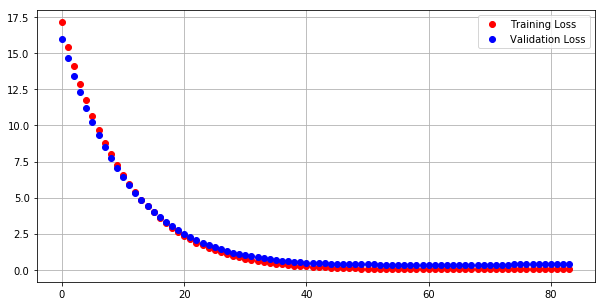

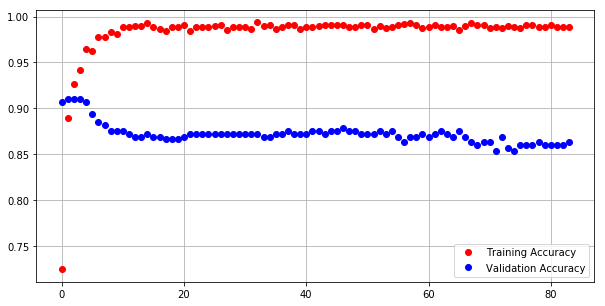

In [17]:
# plot accuracy and loss
plot_metric(history.history['loss'],history.history['val_loss'],'Loss')
plot_metric(history.history['acc'],history.history['val_acc'],'Accuracy')

In [18]:
# evaluate on test set
test_proba = mdl.predict(X_test)
test_pred_labels = np.argmax(test_proba,axis=1)

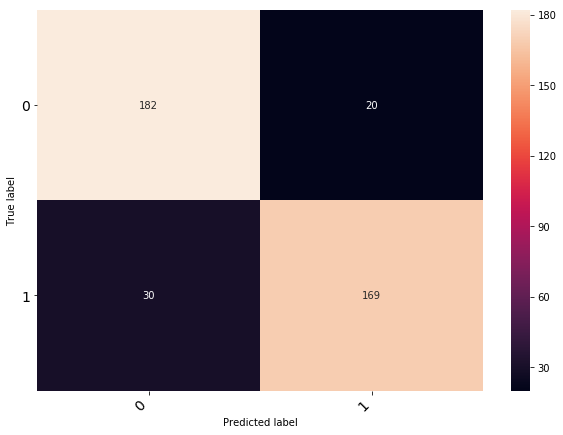

In [19]:
test_conf_mtrx = confusion_matrix(y_test,test_pred_labels)
plot_confusion_matrix(test_conf_mtrx,range(0,num_cls))

### Pseudo Labeling

Pseudo Labeling is one of the first methods used in semi supervised learning. <br>
It is classified under the field of self learning. The whole objective behind it is to augment the unlabled data points in the training procedure as soon as the classifier is confident on the samples. <br>
So basically if the probability emitted by the classifier on an unlabled sample crosses a threshold, this sample is added to the training data with the class label having the maximum probability.

In [21]:
# use same classification model as before
ps_mdl = build_classifier()
ps_mdl.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
epoch_nb = 100
batch_size = 50

In [23]:
# build unlabled dataset
(X_train,X_valid,X_test,X_un),(y_train_categ,y_valid_categ,y_test) = build_dataset()

In [24]:
def get_train_batch(X,y,aug_samples,aug_labels):
    
    '''
    :param X: a matrix having the labled training data
    :param y: a numpy array having the class lables
    :param aug_samples : a list having the highly confident samples
    :param aug_labels : a list having the the labels of the coressponding samples to be augmented
    
    : returns the data and its corresponding labels in batch size
    '''
    
    if len(aug_samples)!=0:
        X = sparse.vstack((X,sparse.vstack(aug_samples)))
        y = np.vstack((y,np.concatenate(aug_labels)))
    
    for idx in range(0,X.shape[0],batch_size):
        data = X[idx:(idx+batch_size)]
        targ = y[idx:(idx + batch_size)]
        
        yield data,targ

In [25]:
def convert_numpy_one_hot(values,num_cls):
    
    '''
    :param values : a list having the labels enumerated
    :param num_cls : a list having total number of classes
    
    :returns : a one hot encoding of values list
    
    This function mainly serves the case where the augmented samples dont cover all of the classes
    thus we need a fixed encoding
    '''
    
    one_hot = np.zeros((values.shape[0],num_cls))
    for i in range(0,values.shape[0]):
        one_hot[i][int(values[i])] = 1
    return one_hot

In [26]:
aug_samples,aug_labels = [],[] # samples to be added to training

train_loss,valid_loss = [],[]
train_acc,valid_acc = [],[]

eps = 0.9 # threshold to keep confident points

for epoch in range(0,epoch_nb):
    
    batch_loss,batch_acc = [],[]
    for batch_samples,batch_targets in get_train_batch(X_train,y_train_categ,aug_samples,aug_labels):
            metric_train = ps_mdl.train_on_batch(batch_samples.todense(),batch_targets)
            batch_loss.append(metric_train[0])
            batch_acc.append(metric_train[1])
            
    
    if X_un.shape[0]>0: # if unlabled data is still not empty 
        unlabled_preds = mdl.predict(X_un.todense()) # get probabilities per sample per class category
        above_thresh_pts_indx = np.where(unlabled_preds > eps)[0] # keep points that are larger than the threshold
        mask = np.zeros(unlabled_preds.shape[0],dtype=bool)
        mask[above_thresh_pts_indx] = True
        if epoch > 10: # give some time for classifier to learn
            if above_thresh_pts_indx.shape[0]>0: # if the number of points to be augmented is non-zeros
                aug_samples.append(X_un[mask])
                aug_labels.append(convert_numpy_one_hot(np.argmax(unlabled_preds[above_thresh_pts_indx],axis=1),num_cls))
                X_un = X_un[~mask] # remove augmented samples

        
    val_eval = ps_mdl.evaluate(X_valid,y_valid_categ,batch_size=batch_size,verbose=0)
    train_loss.append(np.mean(batch_loss))
    valid_loss.append(val_eval[0])
    train_acc.append(np.mean(batch_acc))
    valid_acc.append(val_eval[1])

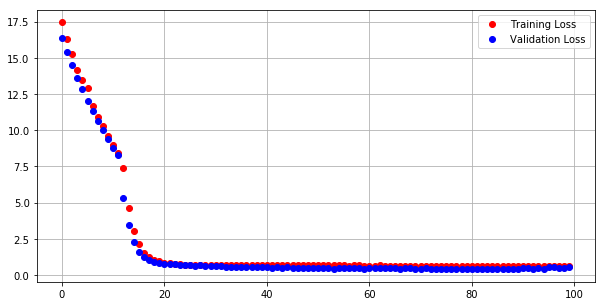

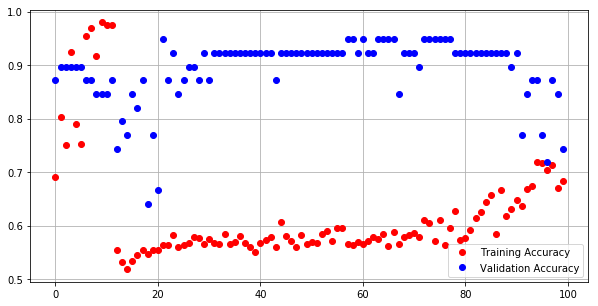

In [27]:
# plot accuracy and loss
plot_metric(train_loss,valid_loss,'Loss')
plot_metric(train_acc,valid_acc,'Accuracy')

In [28]:
# evaluate on test set
test_proba = ps_mdl.predict(X_test)
test_pred_labels = np.argmax(test_proba,axis=1)

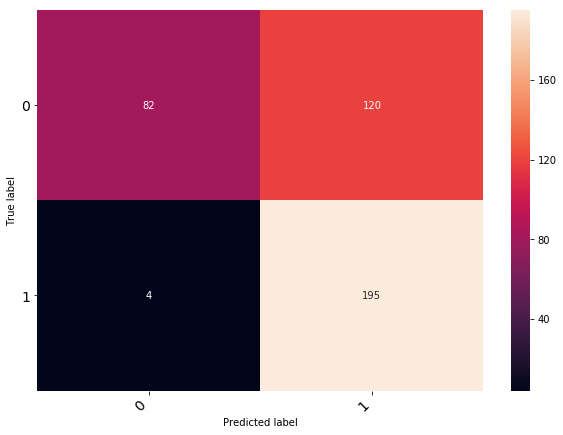

In [29]:
test_conf_mtrx = confusion_matrix(y_test,test_pred_labels)
plot_confusion_matrix(test_conf_mtrx,range(0,num_cls))

### Virtual Adversarial Training

This method was presented in : <a href="https://arxiv.org/pdf/1605.07725.pdf"> here </a> <br>

The principle behind this method is to apply adversarial training on word embeddings in the semi-supervised case.The unlabled points are used in the objective to regularize the model. <br>

The method proceeds as follows:
1. the kl-divergence between the logits of the unlabled points and the perturbed unlabled points is computed (goal is to make them similar)
2. the gradient then w.r.t the perturbed input is computed and is used as the next stage value for the perutrbation
3. the procedure repeats untill the optimal perturbation is found
4. the categorical cross entropy loss of the labled points is regularized with the kl of the logits of the unlabled points and their optimally perturbed versions is computed
5. model is optimized w.r.t the new objective

In [30]:
# build unlabled dataset
(X_train,X_valid,X_test,X_un),(y_train_categ,y_valid_categ,y_test) = build_dataset()

In [31]:
def l2_norm(tensor):
    
    # returns l2 norm of a tensor

    dist = tf.square(tensor)
    dist = tf.reduce_sum(dist)
    dist = tf.sqrt(dist)

    return dist

In [32]:
def normalize_vec(vector):
    
    # normalizes a vector by dividing it by it's l2 norm
    
    norm_computed  = l2_norm(vector)
    factor = K.minimum(1., vector/norm_computed )
    return factor

In [33]:
def logit_kl(q_logit, p_logit):
    
    '''
    :param q_logit : logit of first tensor
    :param p_logit : logit of second tensor
    
    :returns : kl divergence between the two logits
    '''

    q = K.softmax(q_logit,axis=1)
    logq = tf.nn.log_softmax(q_logit,axis=1)
    logp = tf.nn.log_softmax(p_logit,axis=1)

    qlogq = tf.reduce_mean(tf.reduce_sum(q*logq,axis=1))
    qlogp = tf.reduce_mean(tf.reduce_sum(q*logp,axis=1))

    return qlogq - qlogp

In [34]:
def generate_virtual_pert(cls_mdl,input_un,logits_un,eps=2,num_iters=2):
    
    '''
    :param cls_mdl : classifier used to predict logits
    :param input_un : a tensor having unlabled inputs
    :param logits_un : the logits of unlabled points
    :param eps : epsilon to scale perturbation with
    :param num_iters : number of times to repeat in order to get perturbation
    
    :returns : vat loss to be added as a regularizer
    '''
    
    d = K.random_normal(shape=(K.shape(input_un)[0],K.shape(input_un)[1])) # random gaussian
    
    for i in range(num_iters): # number of repetitions
        
        d = 1e-6 *normalize_vec(d) # normalized perturbation
        # predict logits of perturbed input and try to make them similar
        y_hat = cls_mdl(input_un + d) 
        delta_kl = logit_kl(logits_un,y_hat)
        d = K.gradients(delta_kl,d)[0]

    # scale optimal perturbation
    d = normalize_vec(d)
    r_adv = eps *d
    y_hat = cls_mdl(input_un + r_adv)
    delta_kl = logit_kl(logits_un, y_hat)
    return delta_kl

In [35]:
def get_train_batch(data,targets,unlabeled,batch_size=50,un_factor=6):
    
    '''
    :param data : a list having labled training 
    :param targets: a list having targets of labled points
    :param unlabled : a list of unlabled data points
    
    : returns : batches of training data both labled and unlabled
    '''
    
    for idx in range(0,data.shape[0],batch_size):

        data_ = data[idx:(idx+batch_size)]
        targ = targets[idx:(idx + batch_size)]
        un = unlabeled[(idx*un_factor):((idx + batch_size)*un_factor)]
        
        yield data_,targ,un

In [36]:
def compute_softmax(logits):
    
    input_ = Input((num_cls,))
    proba = Activation('softmax')(input_)
    
    with tf.Session() as sess:
        proba_np = sess.run(proba,feed_dict={input_:logits})
    return proba_np

In [37]:
def train_vat(lambda_=0.1):
    
    # build model
    cls_mdl = build_classifier(False)

    input_labeled = Input(shape=(tokens_dim,))
    input_unlabled = Input(shape=(tokens_dim,))
    label_info = Input(shape=(num_cls,))
    vat_mdl = Model([input_labeled,input_unlabled,label_info],cls_mdl(input_labeled))

    # normal loss for classification
    logits_labeled = cls_mdl(input_labeled)
    labled_loss = K.mean(categorical_crossentropy(label_info,Activation('softmax')(logits_labeled)))
    
    # vat loss computed in generate_virtual_pert function
    logits_unlabled = cls_mdl(input_unlabled)
    vat_loss = K.mean(generate_virtual_pert(cls_mdl,input_unlabled,logits_unlabled))
    
    total_loss = labled_loss + lambda_ * vat_loss
    vat_mdl.add_loss(total_loss)
    
    return vat_mdl

In [38]:
vat_mdl = train_vat()
vat_mdl.compile(optimizer='adam')

In [39]:
train_loss,valid_loss = [],[]
for epoch in range(0,100):
    batch_loss = []
    for batch_samples,batch_targets,batch_un in get_train_batch(X_train,y_train_categ,X_un):
        metric_train = vat_mdl.train_on_batch([batch_samples.todense(),batch_un.todense(),batch_targets],None)
        batch_loss.append(metric_train)
    train_loss.append(np.mean(batch_loss))
    
    # validation
    valid_loss.append(vat_mdl.evaluate([X_valid,X_valid,y_valid_categ],None,verbose=0))
    

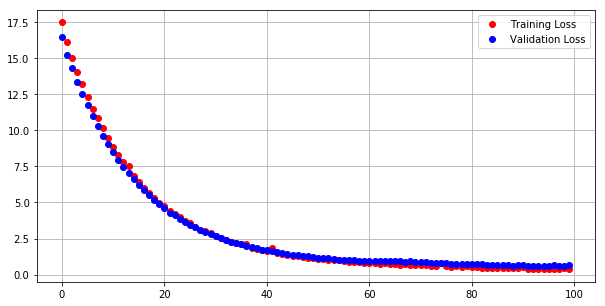

In [40]:
plot_metric(train_loss,valid_loss,'Loss')

In [41]:
y_test_categ = to_categorical(y_test)

In [42]:
test_logits = vat_mdl.predict([X_test,X_test,y_test_categ])
test_proba = compute_softmax(test_logits)
test_pred_labels = np.argmax(test_proba,axis=1)

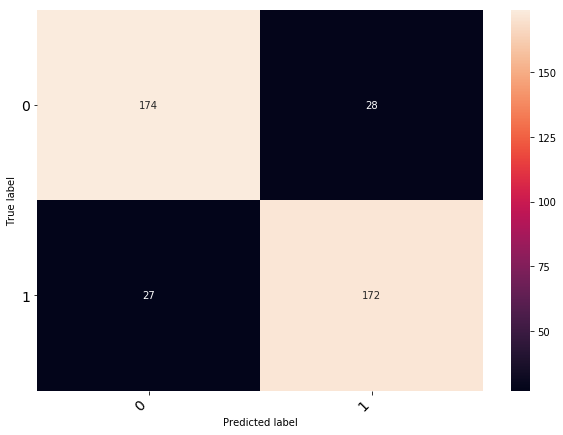

In [43]:
test_conf_mtrx = confusion_matrix(y_test,test_pred_labels)
plot_confusion_matrix(test_conf_mtrx,range(0,num_cls))

### Stacked M1+M2 model

This method refers to : <a href="https://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf">here</a>

<br>
The idea behind it is to take advantage of Variational Autoencoders for semi supervised learning.
The training procedure is as follows: 
1. Encode both labled and unlabled data points
2. Classify both labled and unlabled points
3. decode both abled and unlabled points
4. optimization problem includes reconstruction and kl divergence losses for both types of data, However classification loss is added to the objective however reconstructions of unlabled points are scaled by the probabilites estimated by the classifier for unlabled points

In [44]:
def reparimetrization_trick(mu,log_std):
    
    '''
    :param mu : the estimated mean by vae of a gaussian distribution
    :param log_std : the estimated log varaince by vae of a gaussian distribution
    
    :returns : the sampled points from a gaussian having mean = mu and std = exp(log_std)
    '''
    
    def sampling(args):
        
        mu,log_std = args
        batch = K.shape(mu)[0]
        dim = K.int_shape(log_std)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        # sampling applied by adding the mean to a random normal multiplied by the standard deviation
        return mu + K.exp(0.5 * log_std) * epsilon
    
    return Lambda(sampling)([mu,log_std])

In [45]:
def build_encoder():
   
    input_vec = Input(shape=(tokens_dim,))
    dropout_rate = 0.4
    
    
    ############# first block ########################
    conv_one  = Dense(512,activation='relu',kernel_initializer='glorot_uniform')(input_vec)
    drop_one  = Dropout(dropout_rate)(conv_one)
    bn_one    = BatchNormalization()(drop_one)
    
    ############# second block ########################
    conv_two  = Dense(128,activation='relu',kernel_initializer='glorot_uniform')(bn_one)
    drop_two  = Dropout(dropout_rate)(conv_two)
    bn_two    = BatchNormalization()(drop_two)
    
    
    ########### first cls block ##################
    fc_layer_first = Dense(64,kernel_regularizer=l2(0.2),bias_regularizer=l2(0.2),activation='relu')(bn_two)
    dp_layer_first = Dropout(dropout_rate)(fc_layer_first)
    bn_layer_first = BatchNormalization()(dp_layer_first)
   
    mu  = Dense(32,activation='linear')(bn_layer_first)
    log_std = Dense(32,activation='linear')(bn_layer_first)
    z = reparimetrization_trick(mu,log_std)
    
    return Model(input_vec,[z,mu,log_std],name='encoder')  

In [46]:
def build_decoder():
    
    input_latent = Input(shape=(32 + num_cls,))
    dropout_rate = 0.4
    
    
    ############# first block ########################
    conv_one  = Dense(64,activation='relu',kernel_initializer='glorot_uniform')(input_latent)
    drop_one  = Dropout(dropout_rate)(conv_one)
    bn_one    = BatchNormalization()(drop_one)
    
    ############# second block ########################
    conv_two  = Dense(128,activation='relu',kernel_initializer='glorot_uniform')(bn_one)
    drop_two  = Dropout(dropout_rate)(conv_two)
    bn_two    = BatchNormalization()(drop_two)
    
    
    ########### first cls block ##################
    fc_layer_first = Dense(512,kernel_regularizer=l2(0.2),bias_regularizer=l2(0.2),activation='relu')(bn_two)
    dp_layer_first = Dropout(dropout_rate)(fc_layer_first)
    bn_layer_first = BatchNormalization()(dp_layer_first)
   
    reconst = Dense(tokens_dim,activation='relu')(bn_layer_first)
    
    return Model(input_latent,reconst,name='decoder')

In [47]:
def get_train_batch(data,targets,unlabeled,batch_size=50,un_factor=6):
    
    '''
    :param data : a list having labled training 
    :param targets: a list having targets of labled points
    :param unlabled : a list of unlabled data points
    
    : returns : batches of training data both labled and unlabled
    '''
    
    for idx in range(0,data.shape[0],batch_size):

        data_ = data[idx:(idx+batch_size)]
        targ = targets[idx:(idx + batch_size)]
        un = unlabeled[(idx*un_factor):((idx + batch_size)*un_factor)]
        
        yield data_,targ,un

In [48]:
def create_appending_list(x,pos,num_cls):
    
    '''
    :param x: embedding of a value at a certain step
    :param pos : position to add categorical of one
    :param num_cls : denotes number of classes
    
    :returns a list having the embedding concatenated with a one hot encoding of that position
    '''
    
    lst = [x]
    for i in range(0,num_cls):
        if i == pos:
            lst.append(tf.ones_like(x)[:,0:1])
        else:
            lst.append(tf.zeros_like(x)[:,0:1])
    return lst

In [49]:
def build_m1_m2_model():
    
    # get models
    enc_mdl,dec_mdl = build_encoder(),build_decoder()
    cls_mdl = build_classifier()
    
    input_labeled   = Input(shape=(tokens_dim,))
    input_unlabeled = Input(shape=(tokens_dim,))
    label_info = Input(shape=(num_cls,))
    
    # encode labled and unlabled data
    embed_labeled,mu_labeled,log_std_labeled  = enc_mdl(input_labeled)
    embed_unlabled,mu_unlabeled,log_std_unlabeled = enc_mdl(input_unlabeled)
    
    # classify labled and unlabled data
    y_pred_label   = cls_mdl(input_labeled)
    y_pred_label = Lambda(lambda x:x,name='Classifier1')(y_pred_label)
    y_pred_unlabel = cls_mdl(input_unlabeled)
    y_pred_unlabel =  Lambda(lambda x:x,name='Classifier2')(y_pred_unlabel)
    
    # create one hot encodings of unlabled embeddings with all possible classess
    merge_unlabled_vecs = []
    for i in range(0,num_cls):
        merged_vec = Lambda(lambda x : K.concatenate(create_appending_list(x,i,num_cls),axis=-1))(embed_unlabled)
        merge_unlabled_vecs.append(merged_vec)
    
    
    # decode labled data points concatenate with one hot encoding of their corresponding lables
    merge_labeled_vecs = Concatenate()([embed_labeled,label_info])
    label_reconst = dec_mdl(merge_labeled_vecs)
    label_reconst = Lambda(lambda x:x,name='Autoencoder_Labeled')(label_reconst)
    
    # decode all possible reconstructions of unlabled data points
    unlabel_reconst_vecs = []
    for i in range(0,num_cls):
        reconst_per_label = dec_mdl(merge_unlabled_vecs[i])
        reconst_per_label = Lambda(lambda x:x,name='Autoencoder' + str(i))(reconst_per_label)
        unlabel_reconst_vecs.append(reconst_per_label)
    
    
    # build the model
    mdl = Model([input_labeled,input_unlabeled,label_info],[y_pred_label,y_pred_unlabel,label_reconst] + unlabel_reconst_vecs)
    
    
    # labled data points have both the autoencoder loss and the classification loss
    autoencoder_labeled_loss = K.mean(mse(K.batch_flatten(label_reconst),K.batch_flatten(input_labeled)) + (-0.5 * K.sum(1 + log_std_labeled - K.square(mu_labeled) - K.exp(log_std_labeled),axis=-1)))
    classification_loss = K.mean(categorical_crossentropy(label_info,y_pred_label))
   
    # unlabled points have their autoencoder loss rescaled by the probabilites estimated by classifier
    kl_unlabled_loss = (-0.5 * K.sum(1 + log_std_unlabeled - K.square(mu_unlabeled) - K.exp(log_std_unlabeled),axis=-1))
    autoencoder_unlabled_loss = 0.0
    for i in range(0,num_cls):
        curr_loss = K.mean((mse(K.batch_flatten(input_unlabeled),K.batch_flatten(unlabel_reconst_vecs[i])) + kl_unlabled_loss) * y_pred_unlabel[:,i])
        autoencoder_unlabled_loss = autoencoder_unlabled_loss + curr_loss
    
    # combine all losses
    total_loss = classification_loss + 0.5* (autoencoder_labeled_loss + autoencoder_unlabled_loss)
    mdl.add_loss(total_loss)
        
    return mdl

In [50]:
mdl = build_m1_m2_model()
mdl.compile(optimizer='adam')

In [51]:
mdl.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 82275)        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 82275)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 32), (None,  42206208    input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 2)            0                                            
__________

In [52]:
(X_train,X_valid,X_test,X_un),(y_train_categ,y_valid_categ,y_test) = build_dataset() 

In [53]:
train_loss,val_loss = [],[]
for epoch in range(0,100):
    
    batch_loss = []
    for batch_samples,batch_targets,batch_un in get_train_batch(X_train,y_train_categ,X_un):
        batch_res = mdl.train_on_batch([batch_samples.todense(),batch_un.todense(),batch_targets],None)
        batch_loss.append(batch_res)
    train_loss.append(np.mean(batch_loss))
        
    val_eval = mdl.evaluate([X_valid,X_valid,y_valid_categ],None,verbose=0)  
    val_loss.append(val_eval)
    print('Validation Loss => {}'.format(val_eval))

ResourceExhaustedError: OOM when allocating tensor with shape[300,82275] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Square_7}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_3/add_6}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
plot_metric(train_loss,valid_loss,'Loss')